In [58]:
%load_ext autoreload
%autoreload 2

import os
import sys
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['JAVA_HOME'] = '/Users/sb0487/Desktop/sb0487/pyspark/zulu15.32.15-ca-jdk15.0.3-macosx_aarch64/zulu-15.jdk/Contents/Home' 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("ggplot")
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go
import cufflinks as cf
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import pandas as pd
import numpy as np
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
from ipywidgets import interact, interact_manual
from pyspark.sql.window import Window
import pendulum as plm
from pyspark.sql.types import IntegerType
from pyspark.sql import DataFrame
import pendulum
from datetime import datetime
cf.go_offline(connected=True)
init_notebook_mode(connected=True)

In [60]:
from pyspark.sql import SparkSession as Session
from pyspark import SparkConf as Conf
from pyspark.sql import functions as F, Window as W
C = F.col

In [61]:
conf = (Conf()
        .set("spark.sql.sources.partitionOverwriteMode", "dynamic")
        .set("spark.driver.memory", "3g")
        .set("spark.sql.broadcastTimeout", "10200")
        .set("spark.driver.maxResultSize", "1g")
#         .set("spark.local.dir","/buffer") 指定shuffle write的路徑
       ) 

In [62]:
spark = (Session
         .builder
         .appName("tradddddd")
         .master("local[4]")# 核心數量
         .config(conf=conf)
         .getOrCreate())

In [63]:
# UI
spark

# 說明

想法: 若期權微笑理論正確，深價外被高估，則表示過去一段時間內，買進價平的call or put 並賣出深價外，應當能獲利

回測商品: 週選

回測時間: 2018/01~2021/07

選擇權資料來源: [證交所](https://www.taifex.com.tw/cht/3/dlOptDailyMarketView)

加權指數資料來源: yfinance (yahoo 提供的 api)

作法: 每週週三買,放到隔週三結算

考量運算速度,以pyspark(平行計算框架)完成

# 注意

週三的月選直接移除

尚未處理週三休假,日期延後問題

# load data

## op data

In [64]:
import os
# 自行至證交所下載,並放到指定目錄方便讀取
path = "/Users/sb0487/Desktop/sb0487/finance/quant_project/data/op_data/2018_to_now_opt"
dirlist = os.listdir(path)

In [65]:
dirlist

['2018_opt_08.csv',
 '2021_opt_05.csv',
 '2021_opt_04.csv',
 '2018_opt_09.csv',
 '2021_opt_06.csv',
 '2021_opt_07.csv',
 '2021_opt_03.csv',
 '2021_opt_02.csv',
 '2021_opt_01.csv',
 '2019_opt_07.csv',
 '2019_opt_12.csv',
 '2019_opt_06.csv',
 '2020_opt_09.csv',
 '2019_opt_10.csv',
 '2019_opt_04.csv',
 '2019_opt_05.csv',
 '2019_opt_11.csv',
 '2020_opt_08.csv',
 '2019_opt_01.csv',
 '2019_opt_02.csv',
 '2019_opt_03.csv',
 '2020_opt_03.csv',
 '2020_opt_02.csv',
 '2020_opt_01.csv',
 '2020_opt_11.csv',
 '2020_opt_05.csv',
 '2019_opt_08.csv',
 '2019_opt_09.csv',
 '2020_opt_04.csv',
 '2020_opt_10.csv',
 '2020_opt_06.csv',
 '2020_opt_12.csv',
 '2020_opt_07.csv',
 '2018_opt_01.csv',
 '2018_opt_02.csv',
 '2018_opt_03.csv',
 '2018_opt_07.csv',
 '2018_opt_06.csv',
 '2018_opt_12.csv',
 '2018_opt_04.csv',
 '2018_opt_10.csv',
 '2018_opt_11.csv',
 '2018_opt_05.csv']

In [66]:
def load_op_data(path:str)->DataFrame:
    opt_sdf = spark.read.csv(path,header = True,encoding = "cp950").where(C("契約")=="TXO") #選擇台指選
    return opt_sdf
opt_sdf = load_op_data(path)

In [67]:
# 觀察欄位
opt_sdf.printSchema()

root
 |-- 交易日期: string (nullable = true)
 |-- 契約: string (nullable = true)
 |-- 到期月份(週別): string (nullable = true)
 |-- 履約價: string (nullable = true)
 |-- 買賣權: string (nullable = true)
 |-- 開盤價: string (nullable = true)
 |-- 最高價: string (nullable = true)
 |-- 最低價: string (nullable = true)
 |-- 收盤價: string (nullable = true)
 |-- 成交量: string (nullable = true)
 |-- 結算價: string (nullable = true)
 |-- 未沖銷契約數: string (nullable = true)
 |-- 最後最佳買價: string (nullable = true)
 |-- 最後最佳賣價: string (nullable = true)
 |-- 歷史最高價: string (nullable = true)
 |-- 歷史最低價: string (nullable = true)
 |-- 是否因訊息面暫停交易: string (nullable = true)
 |-- 交易時段: string (nullable = true)



In [68]:
# 資料筆數
opt_sdf.count()

851272

In [69]:
#看一下資料長相, 要有美日的加權指數資料才能知道哪邊是價平,發現這邊並沒有,因此需要自行抓取
opt_sdf.limit(5).toPandas()

,交易日期,契約,到期月份(週別),履約價,買賣權,開盤價,最高價,最低價,收盤價,成交量,結算價,未沖銷契約數,最後最佳買價,最後最佳賣價,歷史最高價,歷史最低價,是否因訊息面暫停交易,交易時段
0,2018/11/01,TXO,201811W1,8800.0000,買權,-,-,-,-,0,1010,0,-,-,-,-,None,一般
1,2018/11/01,TXO,201811W1,8800.0000,買權,-,-,-,-,0,-,-,-,-,-,-,None,盤後
2,2018/11/01,TXO,201811W1,8800.0000,賣權,2.5,2.5,1.6,2.4,3180,2.4,5093,2,2.5,7.6,1.6,None,一般
3,2018/11/01,TXO,201811W1,8800.0000,賣權,3.8,3.9,2,2.7,991,-,-,2.2,2.8,7.6,2,None,盤後
4,2018/11/01,TXO,201811W1,8900.0000,買權,-,-,-,-,0,915,0,-,-,-,-,None,一般


## 加權指數資料

In [70]:
# 透過yfinance api 拉取加權指數資料, 並轉為我們需要的spark dataframe 形式
def get_stock_price(target_stock = '^TWII',
                    start_date = datetime(2018, 1, 1),
                    end_date = datetime(2021, 7, 31))->DataFrame:
    from pandas_datareader import data
    import yfinance as yf
    yf.pdr_override() #以pandasreader常用的格式覆寫
    TWII_df = data.get_data_yahoo([target_stock], start_date, end_date) 
    TWII_df['交易日期'] = TWII_df.index.strftime("%Y/%m/%d") # formart 日期格式
    TWII_close_df = TWII_df[["Close","交易日期"]].rename(columns={"Close": "加權指數收盤價"}) 
    TWII_close_sdf = spark.createDataFrame(TWII_close_df)
    return TWII_close_sdf


In [71]:
# 打開手機檢查yfinance的資料是否正確
TWII_close_sdf = get_stock_price('^TWII',datetime(2018, 1, 1),datetime(2021, 7, 31))
TWII_close_sdf.toPandas().head(5)

[*********************100%***********************]  1 of 1 completed


,加權指數收盤價,交易日期
0,10710.730469,2018/01/02
1,10801.570312,2018/01/03
2,10848.629883,2018/01/04
3,10879.799805,2018/01/05
4,10915.750000,2018/01/08


## 按照日期將加[權指數資料]join回 [選擇權資料]

In [72]:
# 以交易日期為key, 將兩者join
def join_sdf(opt_sdf:DataFrame ,TWII_close_sdf:DataFrame,key=["交易日期"])->DataFrame:
    joined_sdf = opt_sdf.join(TWII_close_sdf,on = key).orderBy("交易日期")
    return joined_sdf
    

In [73]:
# 檢查資料是否正確
joined_sdf = join_sdf(opt_sdf,TWII_close_sdf)
joined_sdf.limit(10).toPandas()

,交易日期,契約,到期月份(週別),履約價,買賣權,開盤價,最高價,最低價,收盤價,成交量,結算價,未沖銷契約數,最後最佳買價,最後最佳賣價,歷史最高價,歷史最低價,是否因訊息面暫停交易,交易時段,加權指數收盤價
0,2018/01/02,TXO,201801W1,9800.0000,買權,-,-,-,-,0,915,0,-,-,-,-,None,一般,10710.730469
1,2018/01/02,TXO,201801W1,9700.0000,買權,-,-,-,-,0,1010,0,-,-,-,-,None,一般,10710.730469
2,2018/01/02,TXO,201801W1,9700.0000,賣權,-,-,-,-,0,-,-,-,-,-,-,None,盤後,10710.730469
3,2018/01/02,TXO,201801W1,9600.0000,賣權,-,-,-,-,0,0.1,82,-,-,-,-,None,一般,10710.730469
4,2018/01/02,TXO,201801W1,9600.0000,賣權,-,-,-,-,0,-,-,-,-,-,-,None,盤後,10710.730469
5,2018/01/02,TXO,201801W1,9700.0000,買權,-,-,-,-,0,-,-,-,-,-,-,None,盤後,10710.730469
6,2018/01/02,TXO,201801W1,9700.0000,賣權,0.3,0.3,0.3,0.3,1,0.1,199,-,0.3,0.7,0.1,None,一般,10710.730469
7,2018/01/02,TXO,201801W1,9600.0000,買權,-,-,-,-,0,1110,1,-,-,-,-,None,一般,10710.730469
8,2018/01/02,TXO,201801W1,9600.0000,買權,-,-,-,-,0,-,-,-,-,-,-,None,盤後,10710.730469
9,2018/01/02,TXO,201801W1,9800.0000,買權,-,-,-,-,0,-,-,-,-,-,-,None,盤後,10710.730469


# 資料預處理

有三個項目要做

1.因策略是根據固定檔數的價外做買賣,EX:買進價外3檔,放空價外6檔,因此必須與加權指數收盤價做比對,才能知道當前價平合約之履約價

2.將日期轉成the day of week

3.抓出星期四那天的淺價外與深價外的履約價

## 抓出價平

1. 將加權指數收盤價四捨五入合併至其最接近的履約價,ex:12100->12100; 12130->12150
2. 新增一欄位"at_the_money",若該履約價為價平,則"是",otherwise"否"

In [74]:
def get_atm_sdf(sdf:DataFrame)->DataFrame:
    atm_sdf = (
        sdf
        .where(C("交易時段")=="一般") #選擇交易時間"一般"
        .where(C("到期月份(週別)").contains("W")) #選擇週選
        .withColumn("加權指數收盤價_餘數",C("加權指數收盤價")%50)
        .withColumn("加權指數收盤價_扣除餘數加50",C("加權指數收盤價")-C("加權指數收盤價_餘數")+50)
        .withColumn("加權指數收盤價_四捨五入",F.when(C("加權指數收盤價_餘數")>25,C("加權指數收盤價_扣除餘數加50")).otherwise(C("加權指數收盤價_扣除餘數加50")-50))
        .drop("加權指數收盤價_餘數","加權指數收盤價_扣除餘數加50")
        .withColumn("at_the_money",F.when(C("履約價")==C("加權指數收盤價_四捨五入"),"是").otherwise("否"))
        .withColumn("履約價與價平價差",(C("履約價")-C("加權指數收盤價_四捨五入")))
    )
    return atm_sdf


In [75]:
atm_sdf = get_atm_sdf(joined_sdf)

In [77]:
#檢查不是價平者有無錯誤
atm_sdf.where(C("at_the_money")=="否").limit(10).toPandas()

,交易日期,契約,到期月份(週別),履約價,買賣權,開盤價,最高價,最低價,收盤價,成交量,...,最後最佳買價,最後最佳賣價,歷史最高價,歷史最低價,是否因訊息面暫停交易,交易時段,加權指數收盤價,加權指數收盤價_四捨五入,at_the_money,履約價與價平價差
0,2018/01/02,TXO,201801W1,10000.0000,買權,-,-,-,-,0,...,-,-,-,-,None,一般,10710.730469,10700.0,否,-700.0
1,2018/01/02,TXO,201801W1,9800.0000,買權,-,-,-,-,0,...,-,-,-,-,None,一般,10710.730469,10700.0,否,-900.0
2,2018/01/02,TXO,201801W1,9900.0000,賣權,-,-,-,-,0,...,-,-,-,-,None,一般,10710.730469,10700.0,否,-800.0
3,2018/01/02,TXO,201801W1,9700.0000,買權,-,-,-,-,0,...,-,-,-,-,None,一般,10710.730469,10700.0,否,-1000.0
4,2018/01/02,TXO,201801W1,9700.0000,賣權,0.3,0.3,0.3,0.3,1,...,-,0.3,0.7,0.1,None,一般,10710.730469,10700.0,否,-1000.0
5,2018/01/02,TXO,201801W1,9800.0000,賣權,-,-,-,-,0,...,-,-,-,-,None,一般,10710.730469,10700.0,否,-900.0
6,2018/01/02,TXO,201801W1,9900.0000,買權,-,-,-,-,0,...,-,-,-,-,None,一般,10710.730469,10700.0,否,-800.0
7,2018/01/02,TXO,201801W1,9600.0000,買權,-,-,-,-,0,...,-,-,-,-,None,一般,10710.730469,10700.0,否,-1100.0
8,2018/01/02,TXO,201801W1,9600.0000,賣權,-,-,-,-,0,...,-,-,-,-,None,一般,10710.730469,10700.0,否,-1100.0
9,2018/01/02,TXO,201801W1,10000.0000,賣權,0.2,0.2,0.2,0.2,65,...,-,0.3,7,0.2,None,一般,10710.730469,10700.0,否,-700.0


In [78]:
#檢查是價平者有無錯誤
atm_sdf.where(C("at_the_money")=="是").limit(5).toPandas()

,交易日期,契約,到期月份(週別),履約價,買賣權,開盤價,最高價,最低價,收盤價,成交量,...,最後最佳買價,最後最佳賣價,歷史最高價,歷史最低價,是否因訊息面暫停交易,交易時段,加權指數收盤價,加權指數收盤價_四捨五入,at_the_money,履約價與價平價差
0,2018/01/02,TXO,201801W1,10700.0000,賣權,78,78,14,15,49803,...,14.5,15,234,14,None,一般,10710.730469,10700.0,是,0.0
1,2018/01/02,TXO,201801W1,10700.0000,買權,6.1,32,6,31.5,55870,...,31,32,32,0.7,None,一般,10710.730469,10700.0,是,0.0
2,2018/01/03,TXO,201801W2,10800.0000,買權,28,58,28,53,11248,...,52,53,58,28,None,一般,10801.570312,10800.0,是,0.0
3,2018/01/03,TXO,201801W1,10800.0000,買權,2.9,14.5,0.1,0.1,121925,...,-,0.1,14.5,0.1,None,一般,10801.570312,10800.0,是,0.0
4,2018/01/03,TXO,201801W2,10800.0000,賣權,90,90,52,54,6089,...,54,55,90,52,None,一般,10801.570312,10800.0,是,0.0


## 將日期轉成the day of week

In [79]:
# 包成udf
def get_day_of_week(date):
    dt = pendulum.parse(date)
    return dt.day_of_week
func = F.udf(get_day_of_week)

def get_day_of_week_sdf(sdf:DataFrame)->DataFrame:
    day_of_week_sdf = (
        sdf
        .withColumn("day_of_week",func(C("交易日期")))
    )
    return day_of_week_sdf

In [80]:
day_of_week_sdf = get_day_of_week_sdf(atm_sdf)

In [83]:
# 檢查日期轉換有無錯誤
day_of_week_sdf.limit(10).toPandas()

,交易日期,契約,到期月份(週別),履約價,買賣權,開盤價,最高價,最低價,收盤價,成交量,...,最後最佳賣價,歷史最高價,歷史最低價,是否因訊息面暫停交易,交易時段,加權指數收盤價,加權指數收盤價_四捨五入,at_the_money,履約價與價平價差,day_of_week
0,2018/01/02,TXO,201801W1,9600.0000,買權,-,-,-,-,0,...,-,-,-,None,一般,10710.730469,10700.0,否,-1100.0,2
1,2018/01/02,TXO,201801W1,9600.0000,賣權,-,-,-,-,0,...,-,-,-,None,一般,10710.730469,10700.0,否,-1100.0,2
2,2018/01/02,TXO,201801W1,9700.0000,買權,-,-,-,-,0,...,-,-,-,None,一般,10710.730469,10700.0,否,-1000.0,2
3,2018/01/02,TXO,201801W1,9700.0000,賣權,0.3,0.3,0.3,0.3,1,...,0.3,0.7,0.1,None,一般,10710.730469,10700.0,否,-1000.0,2
4,2018/01/02,TXO,201801W1,9800.0000,買權,-,-,-,-,0,...,-,-,-,None,一般,10710.730469,10700.0,否,-900.0,2
5,2018/01/02,TXO,201801W1,9800.0000,賣權,-,-,-,-,0,...,-,-,-,None,一般,10710.730469,10700.0,否,-900.0,2
6,2018/01/02,TXO,201801W1,9900.0000,買權,-,-,-,-,0,...,-,-,-,None,一般,10710.730469,10700.0,否,-800.0,2
7,2018/01/02,TXO,201801W1,9900.0000,賣權,-,-,-,-,0,...,-,-,-,None,一般,10710.730469,10700.0,否,-800.0,2
8,2018/01/02,TXO,201801W1,10000.0000,買權,-,-,-,-,0,...,-,-,-,None,一般,10710.730469,10700.0,否,-700.0,2
9,2018/01/02,TXO,201801W1,10000.0000,賣權,0.2,0.2,0.2,0.2,65,...,0.3,7,0.2,None,一般,10710.730469,10700.0,否,-700.0,2


## 選定要操作的兩檔履約價

以星期三開倉當天的收盤價找出該週要操作的賣賣權賣權

1.價外3檔(淺價外,deep_oftm)

2.價外5檔這兩個商品(深價外,shallow_oftm)

之履約價商品

oftm = out of the mony

In [84]:
#透過deep_oftm_point與shallow_oftm_point這兩個參數決定價外幾檔
#預設以價平加上300點作為深價外,價平家上100點作為淺價外

def select_strike_price(sdf:DataFrame,deep_oftm_point = 250,shallow_oftm_point = 150)->DataFrame:
    overCategory = Window.partitionBy("到期月份(週別)").orderBy(F.desc("到期月份(週別)"))


    strike_price_sdf = (
        sdf
    #     .where((C("day_of_week")=="3")|(C("day_of_week")=="5"))
        .where(C("day_of_week")=="3")
        .withColumn("該週3開倉_加權指數收盤價_四捨五入",F.first("加權指數收盤價_四捨五入").over(overCategory))
        .orderBy("交易日期","到期月份(週別)")
        .withColumn("put_strike_price",
                F.when((C("履約價")==C("該週3開倉_加權指數收盤價_四捨五入")-deep_oftm_point)&(C("買賣權")=="賣權"),"put_deep_oftm")
                .when((C("履約價")==C("該週3開倉_加權指數收盤價_四捨五入")-shallow_oftm_point)&(C("買賣權")=="賣權"),"put_shallow_oftm")
               )

        .withColumn("call_strike_price",
                F.when((C("履約價")==C("該週3開倉_加權指數收盤價_四捨五入")+deep_oftm_point)&(C("買賣權")=="買權"),"call_deep_oftm")
                .when((C("履約價")==C("該週3開倉_加權指數收盤價_四捨五入")+shallow_oftm_point)&(C("買賣權")=="買權"),"call_shallow_oftm")
               )
        .drop("該週3開倉_加權指數收盤價_四捨五入","該週3開倉_加權指數收盤價_四捨五入")
        .where(
            (C("put_strike_price").isNotNull())
            |
            (C("call_strike_price").isNotNull())


        )


    )
    return strike_price_sdf

In [85]:
strike_price_sdf = select_strike_price(day_of_week_sdf,300,50)
strike_price_df = strike_price_sdf.toPandas()

In [86]:
"""
再次檢查
1.該日期的加權指數收盤價是否正確
2.價內價外判斷是否正確
3.星期幾的轉換是否正確
"""

strike_price_df.iloc[0:50]

,交易日期,契約,到期月份(週別),履約價,買賣權,開盤價,最高價,最低價,收盤價,成交量,...,歷史最低價,是否因訊息面暫停交易,交易時段,加權指數收盤價,加權指數收盤價_四捨五入,at_the_money,履約價與價平價差,day_of_week,put_strike_price,call_strike_price
0,2018/01/03,TXO,201801W1,10500.0000,賣權,0.3,0.4,0.1,0.1,3772,...,0.1,None,一般,10801.570312,10800.0,否,-300.0,3,put_deep_oftm,None
1,2018/01/03,TXO,201801W1,10750.0000,賣權,18.5,24,0.1,0.1,84171,...,0.1,None,一般,10801.570312,10800.0,否,-50.0,3,put_shallow_oftm,None
2,2018/01/03,TXO,201801W1,10850.0000,買權,0.4,1.6,0.1,0.1,13916,...,0.1,None,一般,10801.570312,10800.0,否,50.0,3,None,call_shallow_oftm
3,2018/01/03,TXO,201801W1,11100.0000,買權,0.1,0.1,0.1,0.1,20,...,0.1,None,一般,10801.570312,10800.0,否,300.0,3,None,call_deep_oftm
4,2018/01/03,TXO,201801W2,10500.0000,賣權,4,5.8,3.3,3.4,5526,...,3.3,None,一般,10801.570312,10800.0,否,-300.0,3,put_deep_oftm,None
5,2018/01/03,TXO,201801W2,10750.0000,賣權,54,83,33.5,34.5,12063,...,33.5,None,一般,10801.570312,10800.0,否,-50.0,3,put_shallow_oftm,None
6,2018/01/03,TXO,201801W2,10850.0000,買權,16,34.5,14,30,11188,...,14,None,一般,10801.570312,10800.0,否,50.0,3,None,call_shallow_oftm
7,2018/01/03,TXO,201801W2,11100.0000,買權,0.6,1,0.6,0.7,2608,...,0.6,None,一般,10801.570312,10800.0,否,300.0,3,None,call_deep_oftm
8,2018/01/10,TXO,201801W2,10500.0000,賣權,0.1,0.1,0.1,0.1,150,...,0.1,None,一般,10831.089844,10850.0,否,-350.0,3,put_deep_oftm,None
9,2018/01/10,TXO,201801W2,10750.0000,賣權,0.3,1.1,0.1,0.1,11503,...,0.1,None,一般,10831.089844,10850.0,否,-100.0,3,put_shallow_oftm,None


# 策略與結果

## 策略1,價差

In [87]:

def execution_strategy(sdf,買賣權 = "賣權",fee:"point"=1,買進賣遠 = True)->DataFrame:
    overCategory = Window.partitionBy(["到期月份(週別)","put_strike_price","call_strike_price"]).orderBy(F.asc("交易日期"))
    if 買進賣遠:
        sign = -1
    else:
        sign = 1
    if 買賣權 == "賣權":
        result_sdf = (
            sdf
        #     .where(C("買賣權")=="賣權")
            .withColumn("put_profit_deep",
                        F.when(C("put_strike_price")=="put_deep_oftm",(C("收盤價")-F.lag("收盤價").over(overCategory))*sign-fee).otherwise(0)
                       )
            .withColumn("put_profit_shallow",
                        F.when(C("put_strike_price")=="put_shallow_oftm",(-C("收盤價")+F.lag("收盤價").over(overCategory))*sign-fee).otherwise(0)
                       )
            .withColumn("total_profit",C("put_profit_deep")+C("put_profit_shallow"))
        )
    if 買賣權 == "買權":
        result_sdf = (
            sdf
        #     .where(C("買賣權")=="賣權")
            .withColumn("call_profit_deep",
                        F.when(C("call_strike_price")=="call_deep_oftm",(C("收盤價")-F.lag("收盤價").over(overCategory))*sign-fee).otherwise(0)
                       )
            .withColumn("call_profit_shallow",
                        F.when(C("call_strike_price")=="call_shallow_oftm",(-C("收盤價")+F.lag("收盤價").over(overCategory))*sign-fee).otherwise(0)
                       )
            .withColumn("total_profit",C("call_profit_deep")+C("call_profit_shallow"))
        )

    result_sdf=(

        result_sdf
        .withColumn("total_profit",F.when(C("total_profit").isNotNull(),C("total_profit")).otherwise(0))
        .orderBy("交易日期","到期月份(週別)")

    )
        
        
        
           
    return result_sdf 

In [88]:
# 視覺化
def visualize(sdf):
    #取出獲利欄位
    profit_sdf = (
        sdf
        .groupBy("交易日期")
        .agg(F.sum("total_profit").alias("total_profit"))
        .orderBy("交易日期")
    )
    profit_df = profit_sdf.toPandas()
    profit_df["sum_profit"] = profit_df["total_profit"].cumsum()
    #繪圖
    layout = go.Layout(title='累計獲利圖', xaxis=dict(title='Date'), yaxis=dict(title='Point'))


    
    data = [
    {
        'x': profit_df.交易日期,    
        'y': profit_df.sum_profit,
        
    }
        
    
    ]
    
    profit_df.iplot(data = data, layout = layout)
    return profit_df
    

In [89]:
"""
策略測試
"""
strike_price_sdf = select_strike_price(day_of_week_sdf,250,150)
result_sdf = execution_strategy(strike_price_sdf,"賣權",1,買進賣遠 = False)
profit_df = visualize(result_sdf)

In [90]:
# 檢查數字有無算錯
result_df = result_sdf.toPandas()
result_df.iloc[0:50]

,交易日期,契約,到期月份(週別),履約價,買賣權,開盤價,最高價,最低價,收盤價,成交量,...,加權指數收盤價,加權指數收盤價_四捨五入,at_the_money,履約價與價平價差,day_of_week,put_strike_price,call_strike_price,put_profit_deep,put_profit_shallow,total_profit
0,2018/01/03,TXO,201801W1,10650.0000,賣權,1,1.9,0.1,0.1,20595,...,10801.570312,10800.0,否,-150.0,3,put_shallow_oftm,None,0.0,NaN,0.0
1,2018/01/03,TXO,201801W1,10550.0000,賣權,0.3,0.4,0.1,0.1,3654,...,10801.570312,10800.0,否,-250.0,3,put_deep_oftm,None,NaN,0.0,0.0
2,2018/01/03,TXO,201801W1,10950.0000,買權,0.1,0.1,0.1,0.1,360,...,10801.570312,10800.0,否,150.0,3,None,call_shallow_oftm,0.0,0.0,0.0
3,2018/01/03,TXO,201801W2,10950.0000,買權,3.5,9.1,2.8,7.1,5270,...,10801.570312,10800.0,否,150.0,3,None,call_shallow_oftm,0.0,0.0,0.0
4,2018/01/03,TXO,201801W2,10550.0000,賣權,7,9,4.6,4.8,10315,...,10801.570312,10800.0,否,-250.0,3,put_deep_oftm,None,NaN,0.0,0.0
5,2018/01/03,TXO,201801W2,10650.0000,賣權,26,26,12.5,13,7241,...,10801.570312,10800.0,否,-150.0,3,put_shallow_oftm,None,0.0,NaN,0.0
6,2018/01/10,TXO,201801W2,10950.0000,買權,3.3,5.8,0.1,0.2,43050,...,10831.089844,10850.0,否,100.0,3,None,call_shallow_oftm,0.0,0.0,0.0
7,2018/01/10,TXO,201801W2,11050.0000,買權,0.2,0.2,0.1,0.1,752,...,10831.089844,10850.0,否,200.0,3,None,call_deep_oftm,0.0,0.0,0.0
8,2018/01/10,TXO,201801W2,10550.0000,賣權,0.2,0.2,0.1,0.1,795,...,10831.089844,10850.0,否,-300.0,3,put_deep_oftm,None,-5.7,0.0,-5.7
9,2018/01/10,TXO,201801W2,10650.0000,賣權,0.2,0.3,0.1,0.1,991,...,10831.089844,10850.0,否,-200.0,3,put_shallow_oftm,None,0.0,11.9,11.9


## 量化策略報率

In [91]:
def get_strategy_performance_report(profit_df,initial_account = 10000):
# 策略起始日與結束日

    """
    假設起始資金10萬(2000點)
    這邊deep copy一下
    """
    import copy
    profit_df = copy.deepcopy(profit_df)
    profit_df["initial_amount_and_sum_profit"] = profit_df["sum_profit"]+initial_account
    start_date = profit_df["交易日期"].iloc[0]
    end_date = profit_df["交易日期"].iloc[-1]

    # 算策略起始日到結束日經過多少天(含假日)
    start = pendulum.parse(start_date)
    end = pendulum.parse(end_date)
    period = end - start
    period_days = period.days
    period_years = period.years
    period_months = period.months

    print("策略執行時間為:",period_years,"年又",period_months,"個月")

    #1.報酬
    return_point = profit_df["initial_amount_and_sum_profit"].iloc[-1] - profit_df["initial_amount_and_sum_profit"].iloc[0] 
    per_of_return = (profit_df["initial_amount_and_sum_profit"].iloc[-1] / profit_df["initial_amount_and_sum_profit"].iloc[0]) 
    if per_of_return<0:
        raise ArithmeticError("破產啦")


    if per_of_return>=1:
        irr = ((per_of_return)**(365/period_days)-1)*100
    else:
        irr = ((per_of_return)**(365/period_days)-1)*100
    irr
    print("獲利點數為:",round(return_point,0))
    print("年化報酬率為:",round(irr,2),"%")


    # 2.計算夏普值
    pct_change = profit_df["initial_amount_and_sum_profit"].pct_change()
    day_profit = pct_change.mean()
    risk = pct_change.std()
    sharpe = day_profit / risk * (252 ** 0.5) #一年252交易天
    print("夏普值是:",sharpe)

    #3.MDD
    MDD = ((np.maximum.accumulate(profit_df["initial_amount_and_sum_profit"]) - profit_df["initial_amount_and_sum_profit"]) ).max()

    print("MDD(最大回撤點數)為:",round(MDD,0))

    # 4.風報比
    return_risk_ratio = return_point/MDD
    print("風報比為",return_risk_ratio)
    return profit_df




In [92]:
profit_df = get_strategy_performance_report(profit_df)

策略執行時間為: 3 年又 6 個月
獲利點數為: 799.0
年化報酬率為: 2.18 %
夏普值是: 2.6673732927407827
MDD(最大回撤點數)為: 146.0
風報比為 5.481481481481514


# 延伸策略

## 單向buy

In [93]:
def select_unilateral_strike_price(sdf:DataFrame,oftm_point = 100)->DataFrame:
    overCategory = Window.partitionBy("到期月份(週別)").orderBy(F.asc("交易日期"))


    strike_price_sdf = (
        sdf
    #     .where((C("day_of_week")=="3")|(C("day_of_week")=="5"))
        .where(C("day_of_week")=="3")
        .withColumn("該週3開倉_加權指數收盤價_四捨五入",F.first("加權指數收盤價_四捨五入").over(overCategory))
        .orderBy("交易日期","到期月份(週別)")
        .withColumn("put_strike_price",
                F.when((C("履約價")==C("該週3開倉_加權指數收盤價_四捨五入")-oftm_point)&(C("買賣權")=="賣權"),"put_oftm_point")
               )

        .withColumn("call_strike_price",
                F.when((C("履約價")==C("該週3開倉_加權指數收盤價_四捨五入")+oftm_point)&(C("買賣權")=="買權"),"call_oftm_point")
               )
        .drop("該週3開倉_加權指數收盤價_四捨五入","該週3開倉_加權指數收盤價_四捨五入")
        .where(
            (C("put_strike_price").isNotNull())
            |
            (C("call_strike_price").isNotNull())


        )


    )
    return strike_price_sdf

In [94]:

def execution_unilateral_strategy(sdf,買賣權 = "賣權",fee:"point"=1,buy = True)->DataFrame:
    overCategory = Window.partitionBy(["到期月份(週別)","put_strike_price","call_strike_price"]).orderBy(F.desc("到期月份(週別)"))
    if buy:
        sign = 1
    else:
        sign = -1
    if 買賣權 == "賣權":
        result_sdf = (
            sdf
        #     .where(C("買賣權")=="賣權")
            .withColumn("total_profit",
                        F.when(C("put_strike_price")=="put_oftm_point",(C("收盤價")-F.lag("收盤價").over(overCategory))*sign-fee).otherwise(0)
                       )
#             .withColumn("put_profit_shallow",
#                         F.when(C("put_strike_price")=="put_shallow_oftm",(-C("收盤價")+F.lag("收盤價").over(overCategory))*sign-fee).otherwise(0)
#                        )
#             .withColumn("total_profit",C("put_profit_deep")+C("put_profit_shallow"))
        )
    if 買賣權 == "買權":
        result_sdf = (
            sdf
        #     .where(C("買賣權")=="賣權")
            .withColumn("total_profit",
                        F.when(C("call_strike_price")=="call_oftm_point",(C("收盤價")-F.lag("收盤價").over(overCategory))*sign-fee).otherwise(0)
                       )
#             .withColumn("call_profit_shallow",
#                         F.when(C("call_strike_price")=="call_shallow_oftm",(-C("收盤價")+F.lag("收盤價").over(overCategory))*sign-fee).otherwise(0)
#                        )
#             .withColumn("total_profit",C("call_profit_deep")+C("call_profit_shallow"))
        )

    result_sdf=(

        result_sdf
        .withColumn("total_profit",F.when(C("total_profit").isNotNull(),C("total_profit")).otherwise(0))
        .orderBy("交易日期","到期月份(週別)")

    )
        
        
        
           
    return result_sdf 

In [95]:

def get_unilateral_strategy_result(day_of_week_sdf,spread = 100,call_or_put = "賣權",buy_or_sell = "buy"):
    """spread為價外多少點, ex: spread = 100表示價外100點 ,若為負數表示價內"""
    if buy_or_sell =="buy":
        buy = True
    if buy_or_sell =="sell":
        buy = False
    
    strike_price_sdf = select_unilateral_strike_price(day_of_week_sdf,spread)
    result_sdf = execution_unilateral_strategy(strike_price_sdf,call_or_put,fee = 1,buy = buy)
    profit_df = visualize(result_sdf)
    return (profit_df,result_sdf)

In [96]:
profit_df,result_sdf = get_unilateral_strategy_result(day_of_week_sdf,spread = 100)

### 策略結果

In [97]:
# 賣賣,put,call,價內外9檔,總共36種組合

spread_list = [-100,-50,0,50,100,150,200,250,300]
call_or_put_list = ["買權","賣權"]
buy_or_sell_list = ["buy","sell"]
# buy_or_sell_list = ["buy"]

# spread_list = [-50,0,50]
# call_or_put_list = ["買權","賣權"]
# buy_or_sell_list = ["buy","sell"]

In [98]:
result_df_list = []
names = locals()
for spread in spread_list:
    for call_or_put in call_or_put_list:
        for buy_or_sell in buy_or_sell_list:
            
            if spread<0:
                abs_spread = abs(spread)
                spread_name = str("負"+str(abs_spread))
            else:
                spread_name = spread
            print(str(buy_or_sell)+"_"+str(call_or_put)+"_"+str(spread_name)+"的獲利如下圖")
            unilateral_result_df,_ = get_unilateral_strategy_result(day_of_week_sdf,spread = spread,call_or_put = call_or_put,buy_or_sell = buy_or_sell)

            names[str(buy_or_sell)+"_"+str(call_or_put)+"_"+str(spread_name)+"_df"] = unilateral_result_df
            result_df_list.append(str(buy_or_sell)+"_"+str(call_or_put)+"_"+str(spread_name)+"_df")
            

buy_買權_負100的獲利如下圖


sell_買權_負100的獲利如下圖


buy_賣權_負100的獲利如下圖


sell_賣權_負100的獲利如下圖


buy_買權_負50的獲利如下圖


sell_買權_負50的獲利如下圖


buy_賣權_負50的獲利如下圖


sell_賣權_負50的獲利如下圖


buy_買權_0的獲利如下圖


sell_買權_0的獲利如下圖


buy_賣權_0的獲利如下圖


sell_賣權_0的獲利如下圖


buy_買權_50的獲利如下圖


sell_買權_50的獲利如下圖


buy_賣權_50的獲利如下圖


sell_賣權_50的獲利如下圖


buy_買權_100的獲利如下圖


sell_買權_100的獲利如下圖


buy_賣權_100的獲利如下圖


sell_賣權_100的獲利如下圖


buy_買權_150的獲利如下圖


sell_買權_150的獲利如下圖


buy_賣權_150的獲利如下圖


sell_賣權_150的獲利如下圖


buy_買權_200的獲利如下圖


sell_買權_200的獲利如下圖


buy_賣權_200的獲利如下圖


sell_賣權_200的獲利如下圖


buy_買權_250的獲利如下圖


sell_買權_250的獲利如下圖


buy_賣權_250的獲利如下圖


sell_賣權_250的獲利如下圖


buy_買權_300的獲利如下圖


sell_買權_300的獲利如下圖


buy_賣權_300的獲利如下圖


sell_賣權_300的獲利如下圖


## 統計套利

藉由買進與賣出各履約價call/put, 創造更高的風報比投資組合

放空sell call = buy call,上一步驟先做出sell與buy的所有組合,方便手續費處理與後續的權重則可以不用有負數

In [100]:
result_df_list

['buy_買權_負100_df',
 'sell_買權_負100_df',
 'buy_賣權_負100_df',
 'sell_賣權_負100_df',
 'buy_買權_負50_df',
 'sell_買權_負50_df',
 'buy_賣權_負50_df',
 'sell_賣權_負50_df',
 'buy_買權_0_df',
 'sell_買權_0_df',
 'buy_賣權_0_df',
 'sell_賣權_0_df',
 'buy_買權_50_df',
 'sell_買權_50_df',
 'buy_賣權_50_df',
 'sell_賣權_50_df',
 'buy_買權_100_df',
 'sell_買權_100_df',
 'buy_賣權_100_df',
 'sell_賣權_100_df',
 'buy_買權_150_df',
 'sell_買權_150_df',
 'buy_賣權_150_df',
 'sell_賣權_150_df',
 'buy_買權_200_df',
 'sell_買權_200_df',
 'buy_賣權_200_df',
 'sell_賣權_200_df',
 'buy_買權_250_df',
 'sell_買權_250_df',
 'buy_賣權_250_df',
 'sell_賣權_250_df',
 'buy_買權_300_df',
 'sell_買權_300_df',
 'buy_賣權_300_df',
 'sell_賣權_300_df']

In [101]:
def merge_result_df(result_df_list):
    all_result_df = names[result_df_list[0]].iloc[:,[0]]
    new_result_df_list = []
    for result_df in result_df_list:
#         if names[result_df].iloc[-1,2]>0:
        all_result_df = pd.merge(all_result_df, names[result_df].iloc[:,[0,2]].rename(columns={'sum_profit':f'sum_profit_{result_df}'}), how='left', on='交易日期')
        new_result_df_list.append(result_df)
    return new_result_df_list,all_result_df

In [102]:
def monte_carlo_get_efficiency_frontier(all_result_df,initial_amount = 10000,risk_free = 0.02,n_times = 100):
    """
    蒙地卡羅
    port_returns儲存報酬率
    port_variance儲存變異度
    weights_list儲存每次權重
    重複N次
    無風險利率設1%
    """
    noc = len(all_result_df.columns)-1
    
    port_returns = []
    port_variance = []
    weights_list = []
    return_risk_ratio_list = []

    risk_free = 0.01
    
    all_result_df.iloc[:,1:]= all_result_df.iloc[:,1:]+initial_amount
    
    returns = np.log(all_result_df.iloc[:,1:] / all_result_df.iloc[:,1:].shift(1))

    returns.mean()*252


    for p in range(n_times):

        # 放空的權重絕對值相加要為1
        weights = np.random.random(noc)

        weights /=np.sum(weights)

        weights_list.append(weights)
        port_returns.append(np.sum(returns.mean()*252*weights))

        port_variance.append(np.sqrt(np.dot(weights.T, np.dot(returns.cov()*252, weights))))
        


    port_returns = np.array(port_returns)

    port_variance = np.array(port_variance)

    plt.figure(figsize = (15,7))

    c=(port_returns-risk_free)/port_variance

    plt.scatter(port_variance, port_returns, c=c, marker = 'o')

    plt.grid(True)

    plt.xlabel('excepted volatility')

    plt.ylabel('expected return')

    plt.colorbar(label = 'Sharpe ratio')
    return weights_list,c

In [103]:
def get_efficent_portfolio(result_df_list,c,fee = 1):
    """
    找出夏普值最高的那個投資組合的那個權重
    """
    i = 0
    print("投組最佳權重是:")
    for result in result_df_list:
        print(result,"的權重為",weights_list[np.where(c==np.max(c))[0][0]][i])
        i+=1

    portfolio_df = pd.concat([all_result_df.iloc[:,0:1],all_result_df.iloc[:,1:]*weights_list[np.where(c==np.max(c))[0][0]]],axis=1)
    portfolio_df["sum_profit"] = portfolio_df[portfolio_df.columns].sum(1)-fee
    portfolio_df = portfolio_df.dropna()
    return portfolio_df


In [104]:
# 視覺化
def visualize_portfolio_df(profit_df):
    #取出獲利欄位
#     profit_df["sum_profit"] = profit_df["total_profit"].cumsum()
    #繪圖
    layout = go.Layout(title='累計獲利圖', xaxis=dict(title='Date'), yaxis=dict(title='Point'))


    
    data = [
    {
        'x': profit_df.交易日期,    
        'y': profit_df.sum_profit,
        
    }
        
    
    ]
    
    profit_df.iplot(data = data, layout = layout)
#     return profit_df

投組最佳權重是:
buy_買權_負100_df 的權重為 0.0438124642180169
sell_買權_負100_df 的權重為 0.015244487724569955
buy_賣權_負100_df 的權重為 0.009187064627045913
sell_賣權_負100_df 的權重為 0.04252206535740879
buy_買權_負50_df 的權重為 0.03164505624646677
sell_買權_負50_df 的權重為 0.046562643202466426
buy_賣權_負50_df 的權重為 0.00019008495274331515
sell_賣權_負50_df 的權重為 0.030025391842432723
buy_買權_0_df 的權重為 0.049601946989406065
sell_買權_0_df 的權重為 0.002535835366155976
buy_賣權_0_df 的權重為 0.0003054651983491385
sell_賣權_0_df 的權重為 0.02451655861250655
buy_買權_50_df 的權重為 0.026249458741853984
sell_買權_50_df 的權重為 0.029954689314629628
buy_賣權_50_df 的權重為 0.0008638669613294946
sell_賣權_50_df 的權重為 0.05110626759997909
buy_買權_100_df 的權重為 0.050158603250239533
sell_買權_100_df 的權重為 0.030569052495335917
buy_賣權_100_df 的權重為 0.027391260227706264
sell_賣權_100_df 的權重為 0.05333942114163269
buy_買權_150_df 的權重為 0.03633031955066544
sell_買權_150_df 的權重為 0.02724332804504923
buy_賣權_150_df 的權重為 0.027177043026639657
sell_賣權_150_df 的權重為 0.050280435155995
buy_買權_200_df 的權重為 0.00162631556955

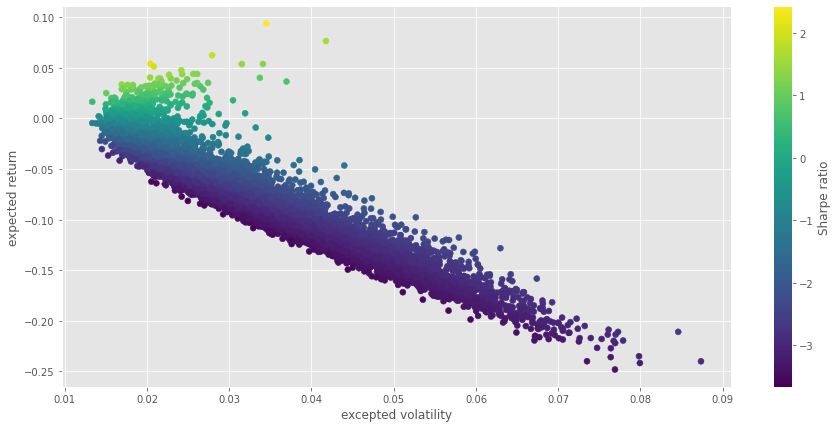

In [105]:
result_df_list ,all_result_df = merge_result_df(result_df_list)
weights_list,c = monte_carlo_get_efficiency_frontier(all_result_df,initial_amount = 10000,risk_free = 0.01,n_times = 10000)
portfolio_df = get_efficent_portfolio(result_df_list,c)
visualize_portfolio_df(portfolio_df)

In [106]:
get_strategy_performance_report(portfolio_df)

策略執行時間為: 3 年又 6 個月
獲利點數為: 1000.0
年化報酬率為: 1.38 %
夏普值是: 2.900213789552659
MDD(最大回撤點數)為: 319.0
風報比為 3.1377335866418377


,交易日期,sum_profit_buy_買權_負100_df,sum_profit_sell_買權_負100_df,sum_profit_buy_賣權_負100_df,sum_profit_sell_賣權_負100_df,sum_profit_buy_買權_負50_df,sum_profit_sell_買權_負50_df,sum_profit_buy_賣權_負50_df,sum_profit_sell_賣權_負50_df,sum_profit_buy_買權_0_df,...,sum_profit_buy_買權_250_df,sum_profit_sell_買權_250_df,sum_profit_buy_賣權_250_df,sum_profit_sell_賣權_250_df,sum_profit_buy_買權_300_df,sum_profit_sell_買權_300_df,sum_profit_buy_賣權_300_df,sum_profit_sell_賣權_300_df,sum_profit,initial_amount_and_sum_profit
0,2018/01/03,438.124642,152.444877,91.870646,425.220654,316.450562,465.626432,1.900850,300.253918,496.019470,...,444.621907,188.243026,281.503472,477.914439,139.354474,446.094143,114.748791,458.383281,9999.000000,19999.000000
1,2018/01/10,438.299892,152.353410,91.475602,426.964058,316.197402,465.905808,1.889635,301.965366,494.605814,...,444.621907,188.243026,281.343015,478.091267,139.332177,446.076299,114.699449,458.488709,10004.103769,20004.103769
2,2018/01/17,438.299892,152.353410,91.475602,426.964058,316.197402,465.905808,1.889635,301.965366,494.605814,...,444.621907,188.243026,281.343015,478.091267,139.332177,446.076299,114.699449,458.488709,10004.103769,20004.103769
3,2018/01/24,442.768763,150.767984,90.355699,432.062454,319.045457,461.622045,1.872755,304.571570,497.978747,...,444.488520,188.261850,281.126258,478.363678,139.307093,446.067377,114.639779,458.635392,10019.488669,20019.488669
4,2018/01/31,441.410577,151.210074,90.126023,433.040461,317.558139,463.717364,1.865152,305.712535,495.106794,...,444.315118,188.297617,280.850384,478.736452,139.269467,446.098604,114.639779,458.635392,10023.064267,20023.064267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,2021/06/30,544.133281,111.778682,42.109829,645.161784,380.224844,360.334327,0.958655,441.754583,612.965980,...,458.431863,178.254851,215.555654,578.501091,147.981909,409.822228,91.323973,542.148242,11021.079750,21021.079750
173,2021/07/07,541.811220,112.556151,40.933885,650.519565,377.914755,363.640275,0.929782,446.255389,608.328198,...,456.546667,179.015353,214.038350,580.981467,147.523433,411.200659,90.804161,544.133042,11038.512336,21038.512336
174,2021/07/14,534.888851,114.934291,40.612338,651.922793,372.414844,371.639737,0.918567,447.966836,601.140876,...,454.728163,179.747618,212.267693,583.891966,147.095615,412.480949,90.185665,546.512051,11046.422127,21046.422127
175,2021/07/21,534.888851,114.934291,40.612338,651.922793,372.414844,371.639737,0.918567,447.966836,601.140876,...,454.728163,179.747618,212.267693,583.891966,147.095615,412.480949,90.185665,546.512051,11046.422127,21046.422127
